# Previsione a 14 giorni

Previsione a 14 giorni con modello SARIMA e Gradient Boosting.

> Max Pierini

**NB: questo articolo è un progetto aperto e ancora in fase di revisione e completamento. Per proposte di collaborazione, scrivere a info@epidata.it**

***

I nuovi casi giornalieri previsti a 14 giorni sono stimati utilizzando un modello di autoregressione $\mathrm{SARIMA}(p,d,q)\times(P,D,Q,s)$, i cui parametri ottimali sono stati determinati per [grid-search](https://towardsdatascience.com/grid-search-for-sarimax-parameters-adbd5104cb8b) sul prodotto cartesiano di range empirici, scegliendo la combinazione di parametri che [minimizzi](https://machinelearningmastery.com/probabilistic-model-selection-measures/) il Bayesian Information Criterion ([BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion)).

In modello migliore è attualmente

$$
\mathrm{SARIMA}(0, 1, 6)\times(0, 1, 10, 7)
$$

I parametri potrebbero essere ulteriormente affinati con successive grid-search mirate.

I nuovi casi ad un giorno sono stimati anche con modello ad albero decisionale [Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) in Supervised Machine Learning (**GBR-SML**) con `scikit-learn`, basato sull'osservazione dei nuovi positivi dei 28 giorni precedenti e i cui parametri ottimali sono stati determinati per grid-search cross-validation. I parametri potrebbero essere ulteriormente affinati grazie a successive grid-search mirate.

In [1]:
import numpy as np
import pandas as pd
import itertools
from pandas.plotting import autocorrelation_plot

import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import Markdown

In [2]:
df = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'], index_col='data'
)

In [3]:
df.index = df.index.normalize()

In [4]:
ts = df[['nuovi_positivi']].dropna()

In [5]:
features_n = 7 * 4
DF = pd.DataFrame(
    columns=[f'day_{i}' for i in range(features_n + 1)],
    index=ts.index[features_n:]
)
for i in range(features_n + 1):
    _df = ts.iloc[i:(ts.index.size - features_n + i)]
    DF.iloc[:,i] = _df.values

In [6]:
X = DF.iloc[:,:features_n]
y = DF.iloc[:,-1].values

In [7]:
mdl_params = {
 'alpha': 0.5,
 'criterion': 'friedman_mse',
 'learning_rate': 0.45,
 'loss': 'quantile',
 'max_depth': 4,
 'min_samples_split': 5,
 'n_estimators': 100
}

In [8]:
mdl = GradientBoostingRegressor(
    **mdl_params
)

In [9]:
GBR_params = mdl.get_params()

In [10]:
for mdl_param in GBR_params:
    print(mdl_param, ':', GBR_params[mdl_param])

alpha : 0.5
ccp_alpha : 0.0
criterion : friedman_mse
init : None
learning_rate : 0.45
loss : quantile
max_depth : 4
max_features : None
max_leaf_nodes : None
min_impurity_decrease : 0.0
min_impurity_split : None
min_samples_leaf : 1
min_samples_split : 5
min_weight_fraction_leaf : 0.0
n_estimators : 100
n_iter_no_change : None
presort : deprecated
random_state : None
subsample : 1.0
tol : 0.0001
validation_fraction : 0.1
verbose : 0
warm_start : False


In [11]:
iterations = 100

y_trains = []
y_trains_pred = []
y_tests = []
y_tests_pred = []
RMSE = []
R2_train = []
R2_test = []
train_scores = []
test_scores = []
futures = []
feature_importances = []
permutation_imps = []

np.random.seed(42)
random_states = np.random.choice(range(5000), iterations, replace=False)

for i in range(iterations):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1)

    mdl = GradientBoostingRegressor(
        **mdl_params
    )
    mdl.set_params(random_state=random_states[i])

    mdl.fit(X_train, y_train)
    y_train_pred = mdl.predict(X_train)
    y_test_pred = mdl.predict(X_test)

    y_trains.append(y_train)
    y_trains_pred.append(y_train_pred)
    y_tests.append(y_test)
    y_tests_pred.append(y_test_pred)

    mse = mean_squared_error(y_test, y_test_pred)
    RMSE.append(np.sqrt(mse))
    #print("The root mean squared error (RMSE) on test set: {:.4f}".format(np.sqrt(mse)))

    R2_train.append(mdl.score(X_train, y_train))
    R2_test.append(mdl.score(X_test, y_test))
    
    n_estimators = mdl.get_params()['n_estimators']
    test_score = np.zeros((n_estimators,), dtype=np.float64)
    for j, y_pred in enumerate(mdl.staged_predict(X_test)):
        test_score[j] = mdl.loss_(y_test, y_pred)
    train_score = mdl.train_score_
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    mdl.fit(X, y)
    future = mdl.predict(DF.iloc[-1, 1:].values.reshape(1, -1))
    futures.append(future)
    
    feature_importance = mdl.feature_importances_
    feature_importances.append(feature_importance)
    
    permutation_imp = permutation_importance(mdl, X, y, n_repeats=10,
                                random_state=random_states[i], n_jobs=-1)
    permutation_imps.append(permutation_imp.importances)

In [12]:
permutation_imps = np.array(permutation_imps).transpose(1,0,2).reshape(28,-1)

In [13]:
future_fit = sps.norm.fit(np.array(futures).ravel())

future_dist = sps.norm(future_fit[0], future_fit[1])

future_x = np.linspace(future_dist.ppf(.0001), future_dist.ppf(.9999))
future_y = future_dist.pdf(future_x)

future_x_90 = np.linspace(future_dist.ppf(.05), future_dist.ppf(.95))
future_y_90 = future_dist.pdf(future_x_90)

future_hi = future_dist.ppf(.95)
future_lo = future_dist.ppf(.05)
future_mu = future_dist.ppf(.5)

X_future = X.index[-1] + pd.Timedelta(days=1)

In [14]:
df.index.name = None

In [15]:
# Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(df.nuovi_positivi, 
                                    order=(0,1,6), 
                                    seasonal_order=(0,1,10,7), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='D')
                                    
# Fit the model
sarimax_fit = sarimax.fit()

In [16]:
forecast = sarimax_fit.forecast()
predict_past = sarimax_fit.predict()
predict_future = sarimax_fit.predict(start=df.index[-1], end=df.index[-1] + pd.Timedelta(days=7*2+1))

# Previsione

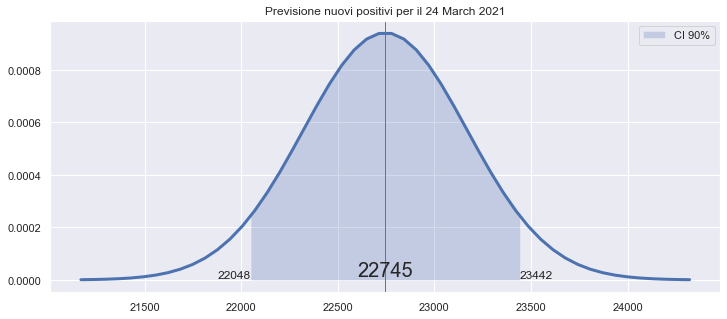

In [17]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(future_x, future_y, lw=3)
ax.fill_between(
    future_x_90,
    future_y_90,
    alpha=.25, label='CI 90%'
)
ax.axvline(future_mu, color='r', lw=1)
ax.text(future_mu, 0, int(future_mu), ha='center', va='bottom', fontsize=20)
ax.text(future_lo, 0, int(future_lo), ha='right', va='bottom')
ax.text(future_hi, 0, int(future_hi), ha='left', va='bottom')
ax.legend()
ax.set(
    title=f'Previsione nuovi positivi per il {X_future.strftime("%d %B %Y")}',
)
plt.show()

In [18]:
#Markdown(f"""
#Previsione per il {X_future.date().strftime('%d %b %Y')}

#- GBR-SML = {Y_future:,.0f}
#- SARIMAX = {forecast.values[0]:,.0f}
#""")

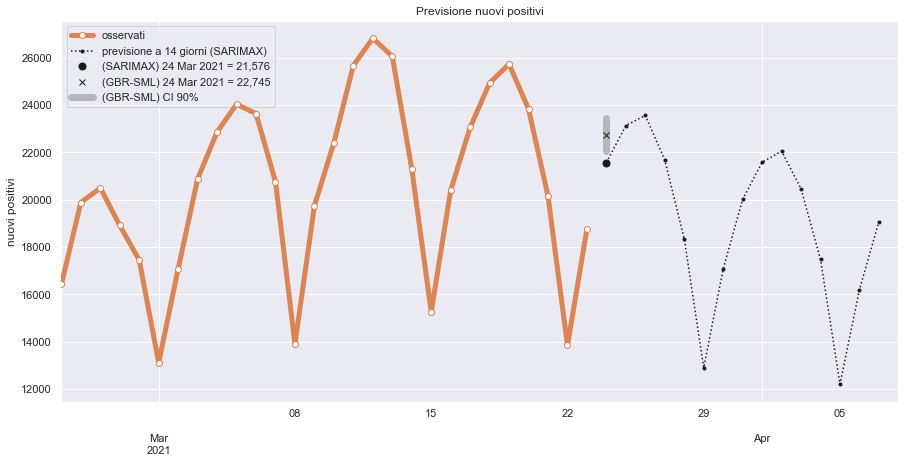

In [19]:
ax = df.iloc[-28:].nuovi_positivi.plot(
    lw=5, marker='o', mfc='w',
    label='osservati', figsize=(15, 7), zorder=100, color='C1'
)
predict_future[1:].plot(ax=ax, color='k', ls=':', marker='.', label='previsione a 14 giorni (SARIMAX)')
ax.plot(
    forecast, marker='o', ms=7, ls='none', color='k', 
    label=f"(SARIMAX) {X_future.date().strftime('%d %b %Y')} = {forecast.values[0]:,.0f}")

ax.plot(
    X_future, future_mu, marker='x', color='k', ls='none',
    label=f"(GBR-SML) {X_future.date().strftime('%d %b %Y')} = {future_mu:,.0f}",
)
ax.plot(
    [X_future, X_future], [future_lo, future_hi], color='k', lw=7, alpha=.25,
    label=f"(GBR-SML) CI 90%",
)

ax.set_xlim(ax.get_xlim()[0], predict_future.index[-1]+pd.Timedelta(days=1))
ax.set(
    title=f'Previsione nuovi positivi',
    ylabel='nuovi positivi'
)
ax.legend(loc='upper left')
plt.show()

# Diagnostica

## SARIMAX

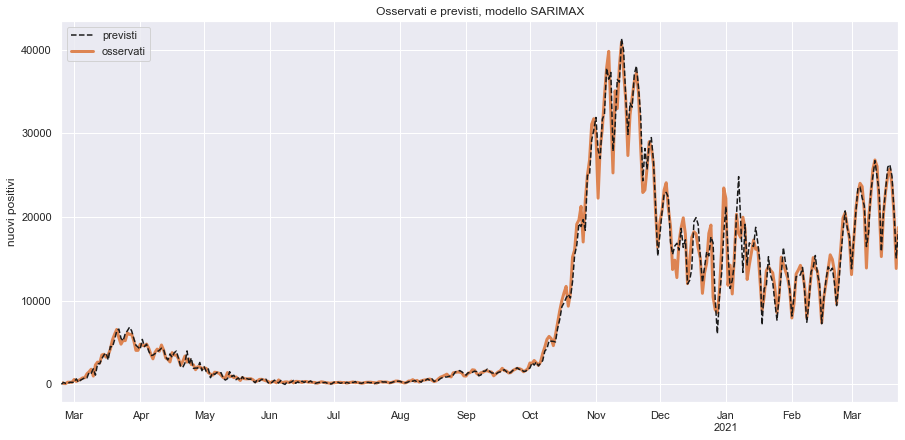

In [20]:
ax = predict_past.plot(
    figsize=(15, 7), title='Osservati e previsti, modello SARIMAX',
    ls='--', zorder=100,
    color='k', label='previsti',
    ylabel='nuovi positivi'
)
df.nuovi_positivi.plot(ax=ax, lw=3, label='osservati', color='C1')
ax.legend(loc='upper left')
plt.show()

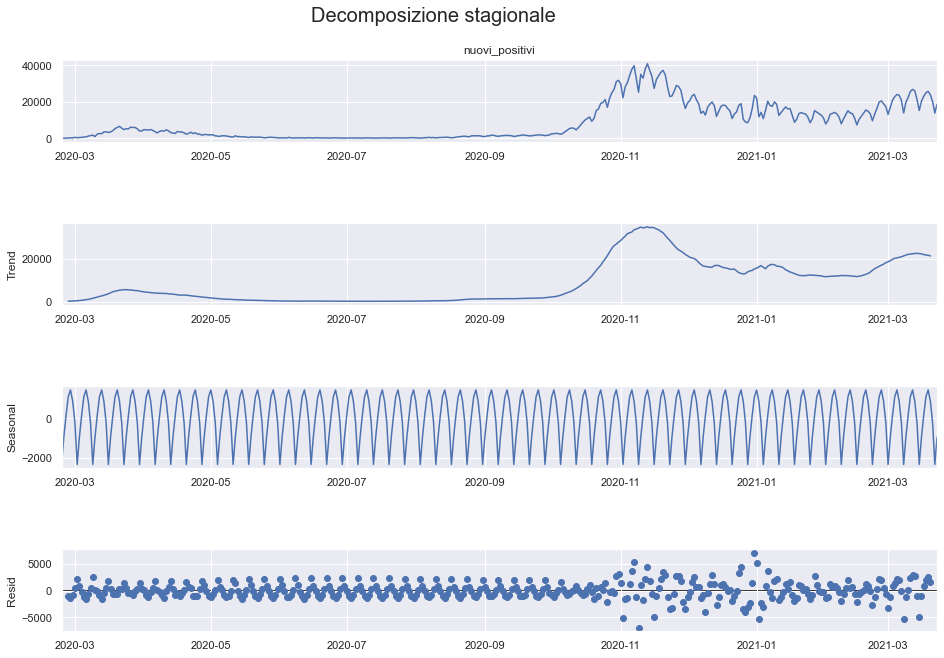

In [21]:
res = sm.tsa.seasonal_decompose(df.nuovi_positivi.dropna())
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle('Decomposizione stagionale', fontsize=20)
plt.show()

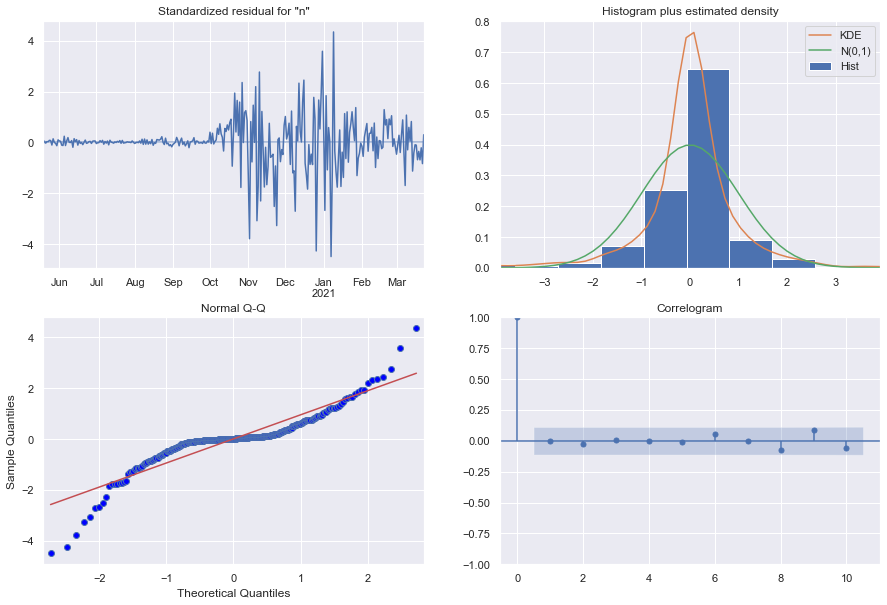

In [22]:
# Plot diagnostics
sarimax_fit.plot_diagnostics(figsize=(15,10));

In [23]:
# Print output summary
sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                    SARIMAX Results                                                    
=======================================================================================================================
Dep. Variable:                                                  nuovi_positivi   No. Observations:                  394
Model:             SARIMAX(0, 1, 6)x(0, 1, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 7)   Log Likelihood               -2687.384
Date:                                                         Tue, 23 Mar 2021   AIC                           5408.767
Time:                                                                 20:10:45   BIC                           5472.234
Sample:                                                             02-24-2020   HQIC                          5434.142
                                                                  - 03-23-2021                                         
Covariance Type:                                                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2096      0.051     -4.077      0.000      -0.310      -0.109
ma.L2         -0.2230      0.044     -5.018      0.000      -0.310      -0.136
ma.L3          0.0462      0.046      0.997      0.319      -0.045       0.137
ma.L4         -0.1176      0.054     -2.194      0.028      -0.223      -0.013
ma.L5          0.1179      0.047      2.531      0.011       0.027       0.209
ma.L6          0.2074      0.049      4.222      0.000       0.111       0.304
ma.S.L7       -0.4217      0.041    -10.360      0.000      -0.502      -0.342
ma.S.L14      -0.2087      0.056     -3.721      0.000      -0.319      -0.099
ma.S.L21      -0.0958      0.062     -1.552      0.121      -0.217       0.025
ma.S.L28       0.0340      0.066      0.516      0.606      -0.095       0.163
ma.S.L35      -0.0713      0.078     -0.916      0.360      -0.224       0.081
ma.S.L42      -0.0599      0.083     -0.723      0.470      -0.222       0.102
ma.S.L49      -0.0436      0.062     -0.699      0.484      -0.166       0.079
ma.S.L56       0.0636      0.087      0.734      0.463      -0.106       0.234
ma.S.L63       0.0095      0.096      0.099      0.921      -0.178       0.197
ma.S.L70       0.0382      0.089      0.430      0.667      -0.136       0.213
sigma2      2.311e+06   1.29e+05     17.969      0.000    2.06e+06    2.56e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               477.24
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):             234.64   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

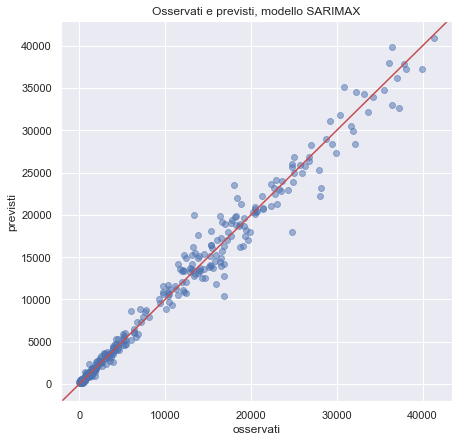

In [24]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(
    predict_past.values, df.nuovi_positivi.values,
    marker='o', ls='none', alpha=.5
)
ax.axline(xy1=(0, 0), slope=1, color='r')
ax.set(
    xlabel='osservati',
    ylabel='previsti',
    title='Osservati e previsti, modello SARIMAX'
)
plt.show()

## Gradient Boosting

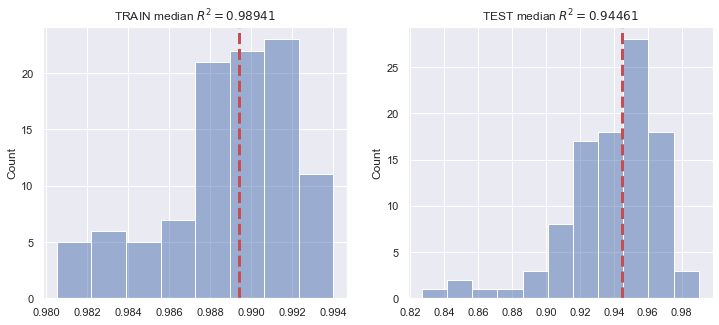

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(R2_train, alpha=.5, ax=ax[0])
ax[0].set(
    title=f"TRAIN median $R^2 = {np.median(R2_train):.5f}$"
)
ax[0].axvline(np.median(R2_train), color='r', ls='--', lw=3)
sns.histplot(R2_test, alpha=.5, ax=ax[1])
ax[1].set(
    title=f"TEST median $R^2 = {np.median(R2_test):.5f}$"
)
ax[1].axvline(np.median(R2_test), color='r', ls='--', lw=3)
plt.show()

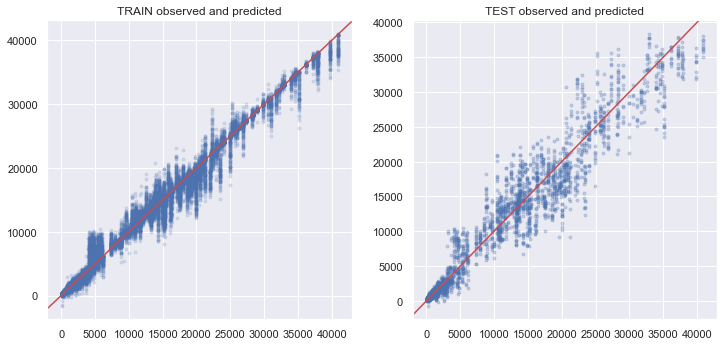

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5.5))
ax[0].plot(y_trains, y_trains_pred, marker='.', ls='none', color='C0', alpha=.15)
ax[0].axline(xy1=(0,0), slope=1, color='r')
ax[0].set(
    title='TRAIN observed and predicted'
)
ax[1].plot(y_tests, y_tests_pred, marker='.', ls='none', color='C0', alpha=.25)
ax[1].axline(xy1=(0,0), slope=1, color='r')
ax[1].set(
    title='TEST observed and predicted'
)
plt.show()

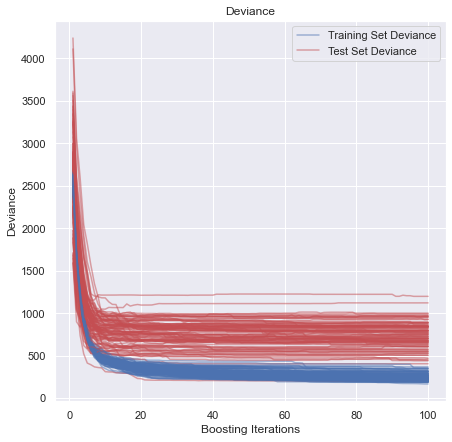

In [27]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title('Deviance')
for i in range(iterations):
    ax.plot(np.arange(n_estimators) + 1, train_scores[i], 'b-',
             alpha=.5,
             label='Training Set Deviance' if not i else None)
    ax.plot(np.arange(n_estimators) + 1, test_scores[i], 'r-',
             alpha=.5,
             label='Test Set Deviance' if not i else None)
ax.legend(loc='upper right')
ax.set_xlabel('Boosting Iterations')
ax.set_ylabel('Deviance')
plt.show()

In [28]:
feature_importance_df = pd.DataFrame(
    feature_importances,
    columns=[f'-{i}' for i in np.arange(1, 29)][::-1]
).melt()

permutation_importance_df = pd.DataFrame(
    permutation_imps.T,
    columns=[f'-{i}' for i in np.arange(1, 29)][::-1]
).melt()

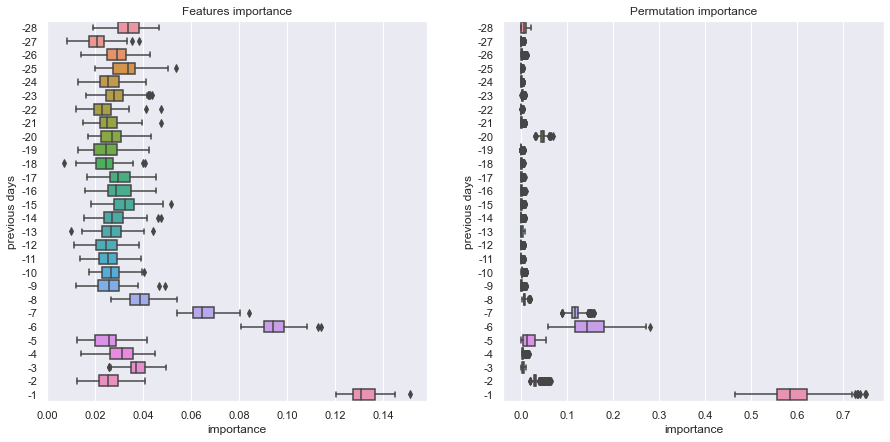

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.boxplot(
    data=feature_importance_df,
    x='value', y='variable',
    ax=ax[0],
)
ax[0].set(
    title='Features importance',
    ylabel='previous days',
    xlabel='importance'
)
sns.boxplot(
    data=permutation_importance_df,
    x='value', y='variable',
    ax=ax[1],
)
ax[1].set(
    title='Permutation importance',
    ylabel='previous days',
    xlabel='importance'
)
plt.show()